# Logistic Regression

In [1]:
include("utils.jl"); using .Utils
checkpkgs("DataFrames", "CSV", "StatsPlots", "GLM", "Distributions", "StatsBase", "OffsetArrays", "Statistics")

## Log Odds

In [2]:
prob(o) = o / (o+1)

prob (generic function with 1 method)

In [3]:
using DataFrames

idx = ["prior", "1 student", "2 students", "3 students"]
o = [10, 10/3, 10/9, 10/27]
p = prob.(o)
table = DataFrame(index= idx, odds = o, prob = p)
table[!, "prob diff"] = ["--"; diff(table.prob)];
table

,index,odds,prob,prob diff
,String,Float64,Float64,Any
1,prior,10.0,0.909091,--
2,1 student,3.33333,0.769231,-0.13986
3,2 students,1.11111,0.526316,-0.242915
4,3 students,0.37037,0.27027,-0.256046


In [4]:
table[!, "log odds"] = log.(table[!, "odds"])
table[!, "log odds diff"] = [ "--"; diff(table[!, "log odds"])]
table

,index,odds,prob,prob diff,log odds,log odds diff
,String,Float64,Float64,Any,Float64,Any
1,prior,10.0,0.909091,--,2.30259,--
2,1 student,3.33333,0.769231,-0.13986,1.20397,-1.09861
3,2 students,1.11111,0.526316,-0.242915,0.105361,-1.09861
4,3 students,0.37037,0.27027,-0.256046,-0.993252,-1.09861


In [5]:
log(1/3)

-1.0986122886681098

## The Space Shuttle Problem

In [6]:
getfile("https://raw.githubusercontent.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/master/Chapter2_MorePyMC/data/challenger_data.csv")

In [7]:
using CSV, Dates
data = CSV.File("challenger_data.csv", dateformat=dateformat"m/d/y") |> DataFrame

# avoiding column names with spaces
rename!(data, "Damage Incident" => "Damage")

# dropping row 4, in which Damage Incident is NaN,
# and row 25, which is the record for the Challenger
filter!(r -> rownumber(r) ∉ [4, 25], data)

# convert the Damage column to integer
data.Damage = parse.(Bool, data.Damage)

# Deal with 2-digit years
data[year.(data.Date) .< 100, "Date"] .+= Dates.Year(1900)

data

,Date,Temperature,Damage
,Date,Int64,Bool
1,1981-04-12,66,0
2,1981-11-12,70,1
3,1982-03-22,69,0
4,1982-01-11,68,0
5,1983-04-04,67,0
6,1983-06-18,72,0
7,1983-08-30,73,0
8,1983-11-28,70,0
9,1984-02-03,57,1


In [8]:
first(data, 5)

,Date,Temperature,Damage
,Date,Int64,Bool
1,1981-04-12,66,0
2,1981-11-12,70,1
3,1982-03-22,69,0
4,1982-01-11,68,0
5,1983-04-04,67,0


In [9]:
nrow(data), count(data[!, "Damage"])

(23, 7)

In [10]:
using StatsPlots

"""Plot damage as a function of temperature.

data: DataFrame
"""
function plot_data(data)
    @df data scatter(:Temperature, :Damage, markershape=:circle, 
         label="data", color=:blue, markeralpha=0.4,
         ylabel="Probability of damage",
         xlabel="Outside temperature (deg F)",
         title="Damage to O-Rings vs Temperature")
end

plot_data

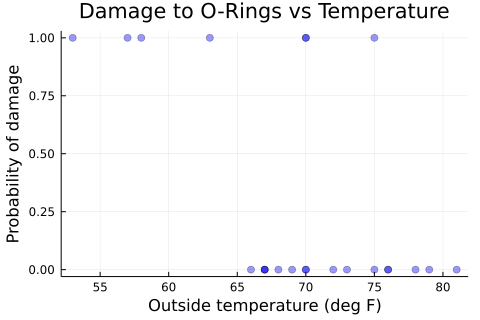

In [11]:
plot_data(data)

In [12]:
using Statistics
offset = round(mean(data.Temperature))
data.x = data.Temperature .- offset
offset

70.0

In [13]:
data.y = data.Damage;

In [14]:
using GLM
fm = @formula(y ~ x)
model = glm(fm, data, Binomial(), LogitLink())

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Binomial{Float64}, LogitLink}, GLM.DensePredChol{Float64, LinearAlgebra.Cholesky{Float64, Matrix{Float64}}}}, Matrix{Float64}}

y ~ 1 + x

Coefficients:
──────────────────────────────────────────────────────────────────────────
                 Coef.  Std. Error      z  Pr(>|z|)  Lower 95%   Upper 95%
──────────────────────────────────────────────────────────────────────────
(Intercept)  -1.20849     0.595023  -2.03    0.0423  -2.37471   -0.0422664
x            -0.232163    0.108137  -2.15    0.0318  -0.444107  -0.0202182
──────────────────────────────────────────────────────────────────────────

In [15]:
inter, slope = coef(model)
xs = range(53, 82, step=1) .- offset;

In [16]:
log_odds = inter .+ slope .* xs;

In [17]:
odds = exp.(log_odds)
ps = odds ./ (odds .+ 1);

In [18]:
mean(ps)

0.4155140416269082

In [19]:
# we'll define expit()
expit(x::Real) = exp(x) / (1.0 + exp(x) )


@. ps = expit(inter + slope * xs);

In [20]:
mean(ps)

0.4155140416269082

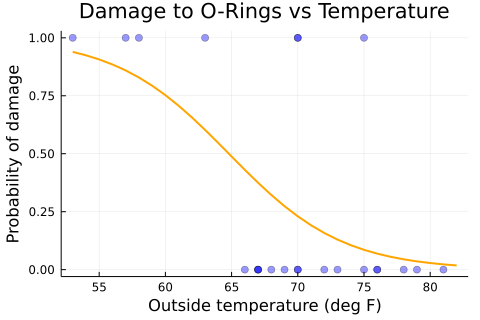

In [21]:
plot_data(data)
plot!(xs.+offset, ps, label="model", color=:orange)

## Prior Distribution

In [22]:
include("empiricaldist.jl"); using .EmpiricalDist

qs = range(-5, 1, length=101)
prior_inter = makeuniform(qs, name="Intercept");

In [23]:
qs = range(-0.8, 0.1, length=101)
prior_slope = makeuniform(qs, name="Slope");

In [24]:
joint = makejoint(prior_inter, prior_slope);

In [25]:
joint_pmf = Pmf(stack(joint))
first(joint_pmf, 3)

┌───────────────┬────────────┐
│               │      probs │
├───────────────┼────────────┤
│  (-0.8, -5.0) │ 9.80296e-5 │
│ (-0.8, -4.94) │ 9.80296e-5 │
│ (-0.8, -4.88) │ 9.80296e-5 │
└───────────────┴────────────┘


## Likelihood

In [26]:
grouped = combine(groupby(data, :x), nrow => :count, :y => sum => :sum)
first(grouped, 5)

,x,count,sum
,Float64,Int64,Int64
1,-17.0,1,1
2,-13.0,1,1
3,-12.0,1,1
4,-7.0,1,1
5,-4.0,1,0


In [27]:
ns = grouped[!, "count"]
ks = grouped[!, "sum"];

In [28]:
xs = grouped.x
ps = expit.(inter .+ slope .* xs);

In [29]:
using Distributions

likes = pdf.(Binomial.(ns, ps), ks)
likes

16-element Vector{Float64}:
 0.9392476159801578
 0.8593162757952032
 0.8288445267274291
 0.6026807913654229
 0.5695069638438955
 0.24446392509022108
 0.67790593118562
 0.7263788859021636
 0.18815013925292395
 0.8419507661095752
 0.8704538397192919
 0.15645192915854367
 0.8666787116533307
 0.9554593529650836
 0.9643585042609903
 0.9772966461784881

In [30]:
prod(likes)

0.00046536445082395316

In [31]:
likelihood = copy(joint_pmf)
for (slope, inter) in keys(joint_pmf)
    ps = expit.(inter .+ slope .* xs)
    likes = pdf.(Binomial.(ns, ps), ks)
    likelihood[(slope, inter)] = prod(likes)
end

## The Update

In [32]:
posterior_pmf = joint_pmf .* likelihood
normalize!(posterior_pmf)

3.508992289655626e-5

In [33]:
DataFrame(:index=>["slope", "inter"],
          :params=>collect(maxprob(posterior_pmf)))

,index,params
,String,Float64
1,slope,-0.233
2,inter,-1.22


In [34]:
DataFrame(coeftable(model))

,Name,Coef.,Std. Error,z,Pr(>|z|),Lower 95%,Upper 95%
,String,Float64,Float64,Float64,Float64,Float64,Float64
1,(Intercept),-1.20849,0.595023,-2.031,0.0422553,-2.37471,-0.0422664
2,x,-0.232163,0.108137,-2.14693,0.0317986,-0.444107,-0.0202182


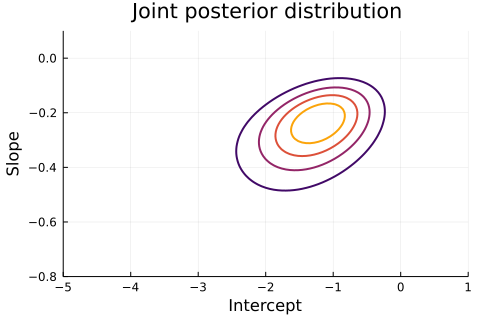

In [35]:
joint_posterior = unstack(posterior_pmf)
contour(joint_posterior, xlabel="Intercept", ylabel="Slope",
        title="Joint posterior distribution")

## Marginal Distributions

In [36]:
marginal_inter = marginal(joint_posterior, 1)
marginal_slope = marginal(joint_posterior, 2);

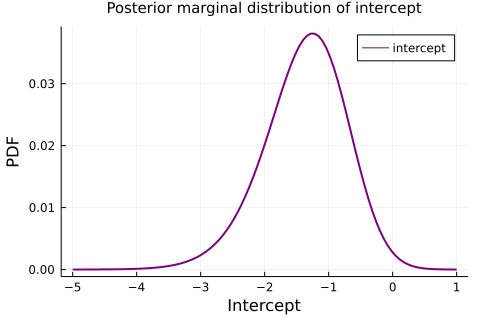

In [37]:
plot(marginal_inter, label="intercept", color=:purple,
         xlabel="Intercept", ylabel="PDF",
         title="Posterior marginal distribution of intercept",
         titlefontsize=10)

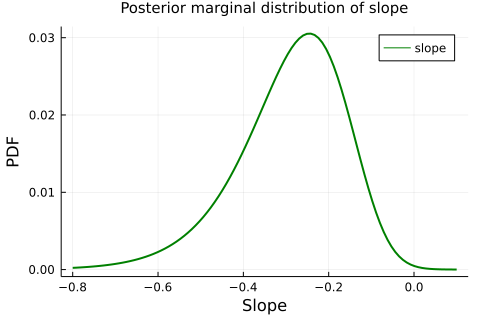

In [38]:
plot(marginal_slope, label="slope", color=:green,
         xlabel="Slope", ylabel="PDF",
         title="Posterior marginal distribution of slope",
         titlefontsize=10)

In [39]:
DataFrame(:index=>["inter", "slope"],
          :mean=>[mean(marginal_inter), mean(marginal_slope)])

,index,mean
,String,Float64
1,inter,-1.37611
2,slope,-0.289795


In [40]:
DataFrame(coeftable(model))

,Name,Coef.,Std. Error,z,Pr(>|z|),Lower 95%,Upper 95%
,String,Float64,Float64,Float64,Float64,Float64,Float64
1,(Intercept),-1.20849,0.595023,-2.031,0.0422553,-2.37471,-0.0422664
2,x,-0.232163,0.108137,-2.14693,0.0317986,-0.444107,-0.0202182


## Transforming Distributions

In [41]:
# note: function goes first to allow for usage such as:
# transform(pmf) do q ... end
"""Transform the quantities in a Pmf."""
function my_transform(func, pmf)
    ps = copy(values(pmf))
    qs = func.(keys(pmf))
    return Pmf(ps, qs)
end

my_transform

In [42]:
marginal_probs = my_transform(expit, marginal_inter);

In [43]:
marginal_probs = transform(expit, marginal_inter);

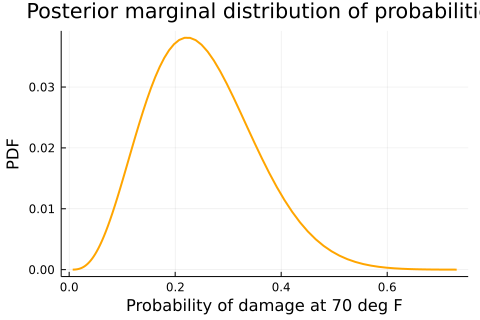

In [44]:
plot(marginal_probs, color=:orange,
         xlabel="Probability of damage at 70 deg F",
         ylabel="PDF",
         title="Posterior marginal distribution of probabilities")

In [45]:
mean_prob = mean(marginal_probs)

0.22019378846479815

In [46]:
marginal_lr = transform(exp, marginal_slope);

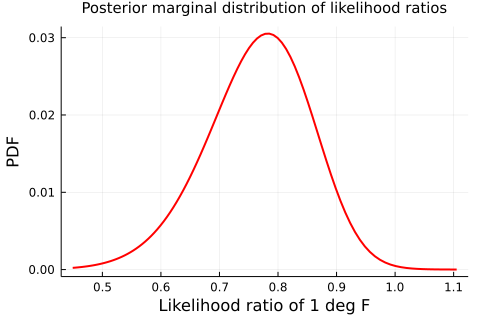

In [47]:
plot(marginal_lr, color=:red,
         xlabel="Likelihood ratio of 1 deg F",
         ylabel="PDF",
         title="Posterior marginal distribution of likelihood ratios",
         titlefontsize=10)

In [48]:
mean_lr = mean(marginal_lr)

0.7542914170110245

In [49]:
expit(mean(marginal_inter)), mean(marginal_probs)

(0.20163497624008214, 0.22019378846479815)

In [50]:
exp(mean(marginal_slope)), mean(marginal_lr)

(0.7484167954660078, 0.7542914170110245)

## Predictive Distributions

In [51]:
import Random
Random.seed!(17)

MersenneTwister(17)

In [52]:
samp = sample(posterior_pmf, 101);

In [53]:
size(samp)

(101,)

In [54]:
typeof(samp)

Vector{Tuple{Float64, Float64}} (alias for Array{Tuple{Float64, Float64}, 1})

In [55]:
eltype(samp)

Tuple{Float64, Float64}

In [56]:
temps = 31:82
xs = temps .- offset;

In [57]:
pred = Matrix{Float64}(undef, (length(samp), length(xs)))

for (i, (slope, inter)) in enumerate(samp)
    for j in 1:length(xs)
        pred[i, j] = expit(inter + slope * xs[j])
    end
end


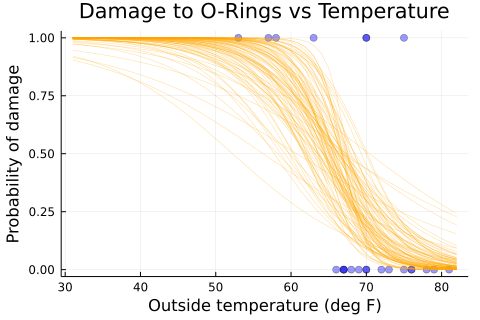

In [58]:
plot_data(data)
for ps in eachrow(pred)
    plot!(temps, ps, color=:orange, lw=0.5, alpha=0.4)
end
plot!()

In [59]:
using StatsBase
low = percentile.(eachcol(pred), 5)
med = percentile.(eachcol(pred), 50)
hi = percentile.(eachcol(pred), 95)

52-element Vector{Float64}:
 0.9999999716035025
 0.9999999530414269
 0.9999999223457905
 0.9999998715851924
 0.9999997876436787
 0.9999996488317386
 0.9999994192820074
 0.9999990396816187
 0.9999984119466311
 0.9999973738787916
 0.9999956572568303
 0.9999929041971445
 0.9999886808131324
 ⋮
 0.376366371701774
 0.3260731128988697
 0.2929705972046154
 0.24379219687275405
 0.21840253609763446
 0.1949753119765887
 0.17350320035626024
 0.1539435638548544
 0.13622551629795251
 0.12025686246775079
 0.10593052783964907
 0.09313023172022387

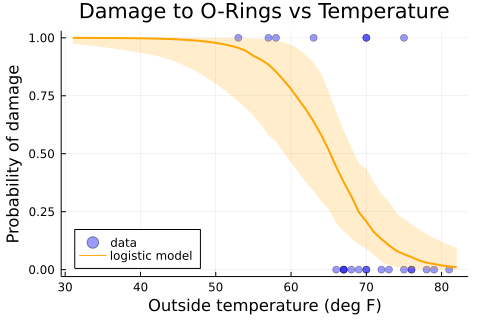

In [60]:
plot_data(data)
plot!(temps, med, color=:orange, label="logistic model", legend=:bottomleft)
plot!(temps, low, fillrange = hi, fillalpha = 0.2, lw=0, color = :orange, label="")

In [61]:
using OffsetArrays

low = OffsetVector(low, temps)
med = OffsetVector(med, temps)
hi = OffsetVector(hi, temps);

In [62]:
t = 80
med[t], (low[t], hi[t])

(0.018523824963299414, (0.0005311153883439866, 0.12025686246775079))

In [63]:
t = 60
med[t], (low[t], hi[t])

(0.7790261077798122, (0.4625701546562505, 0.9692311406428521))

In [64]:
t = 31
med[t], (low[t], hi[t])

(0.9998269920521021, (0.9745683451992629, 0.9999999716035025))

## Empirical Bayes

## Summary

## Exercises

In [65]:
# Solution

prior_log_odds = log(4)

1.3862943611198906

In [66]:
# Solution

lr1 = log(7/5)
lr2 = log(3/5)
lr3 = log(9/5)

lr1, lr2, lr3

(0.3364722366212129, -0.5108256237659907, 0.5877866649021191)

In [67]:
# Solution

# In total, these three outcomes provide evidence that the
# pundit's algorithm is legitmate, although with K=1.8,
# it is weak evidence.

posterior_log_odds = prior_log_odds + lr1 + lr2 + lr3
posterior_log_odds

1.7997276388772319

In [68]:
n = [32690, 31238, 34405, 34565, 34977, 34415, 
                   36577, 36319, 35353, 34405, 31285, 31617]

k = [265, 280, 307, 312, 317, 287, 
                      320, 309, 225, 240, 232, 243];

In [69]:
x = 1:12
n = circshift(n, -8)
k = circshift(k, -8);

In [70]:
n

12-element Vector{Int64}:
 35353
 34405
 31285
 31617
 32690
 31238
 34405
 34565
 34977
 34415
 36577
 36319

In [71]:
adhd = DataFrame(:x=>x, :k=>k, :n=>n)
adhd.rate = adhd.k ./ adhd.n .* 10000
adhd

,x,k,n,rate
,Int64,Int64,Int64,Float64
1,1,225,35353,63.6438
2,2,240,34405,69.7573
3,3,232,31285,74.1569
4,4,243,31617,76.8574
5,5,265,32690,81.0645
6,6,280,31238,89.6344
7,7,307,34405,89.2312
8,8,312,34565,90.2647
9,9,317,34977,90.631


In [72]:
function plot_adhd(adhd)
    scatter(adhd.x, adhd.rate, markertype=:circle, 
             label="data", color=:cyan, alpha=0.4)
    vline!([5.5], color=:gray, alpha=0.2, label="")
    annotate!(
        [(7.5, 64, ("Younger than average", 8)),
         (5, 64, ("Older than average", 8, :right))])

    plot!(xlabel="Birth date, months after cutoff",
             ylabel="Diagnosis rate per 10,000")
end

plot_adhd (generic function with 1 method)

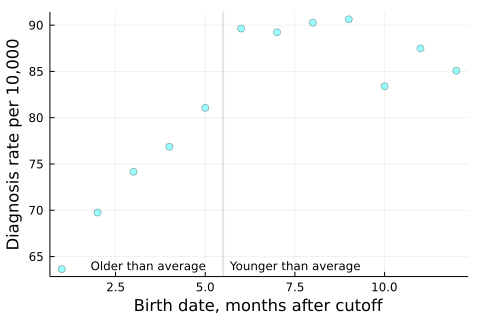

In [73]:
plot_adhd(adhd)

In [74]:
qs = LinRange(-5.2, -4.6, 51)
prior_inter = makeuniform(qs, name="Intercept");

In [75]:
qs = LinRange(0.0, 0.08, 51)
prior_slope = makeuniform(qs, name="Slope");

In [76]:
# Solution

joint = makejoint(prior_inter, prior_slope)
first(joint, 5)

┌────────┬─────────────┬─────────────┬─────────────┬─────────────┬──────────────
│        │        -5.2 │      -5.188 │      -5.176 │      -5.164 │      -5.152 ⋯
├────────┼─────────────┼─────────────┼─────────────┼─────────────┼──────────────
│    0.0 │ 0.000384468 │ 0.000384468 │ 0.000384468 │ 0.000384468 │ 0.000384468 ⋯
│ 0.0016 │ 0.000384468 │ 0.000384468 │ 0.000384468 │ 0.000384468 │ 0.000384468 ⋯
│ 0.0032 │ 0.000384468 │ 0.000384468 │ 0.000384468 │ 0.000384468 │ 0.000384468 ⋯
│ 0.0048 │ 0.000384468 │ 0.000384468 │ 0.000384468 │ 0.000384468 │ 0.000384468 ⋯
│ 0.0064 │ 0.000384468 │ 0.000384468 │ 0.000384468 │ 0.000384468 │ 0.000384468 ⋯
└────────┴─────────────┴─────────────┴─────────────┴─────────────┴──────────────
                                                              46 columns omitted


In [77]:
# Solution

joint_pmf = Pmf(stack(joint))
first(joint_pmf, 3)

┌───────────────┬─────────────┐
│               │       probs │
├───────────────┼─────────────┤
│   (0.0, -5.2) │ 0.000384468 │
│ (0.0, -5.188) │ 0.000384468 │
│ (0.0, -5.176) │ 0.000384468 │
└───────────────┴─────────────┘


In [78]:
# Solution

num_legit = 10
adhd1 = adhd[1:num_legit, :]
adhd2 = adhd[num_legit+1:end, :]
adhd1

,x,k,n,rate
,Int64,Int64,Int64,Float64
1,1,225,35353,63.6438
2,2,240,34405,69.7573
3,3,232,31285,74.1569
4,4,243,31617,76.8574
5,5,265,32690,81.0645
6,6,280,31238,89.6344
7,7,307,34405,89.2312
8,8,312,34565,90.2647
9,9,317,34977,90.631


In [79]:
# Solution

adhd2

,x,k,n,rate
,Int64,Int64,Int64,Float64
1,11,320,36577,87.4867
2,12,309,36319,85.0794


In [80]:
# Solution

likelihood1 = copy(joint_pmf)

xs = adhd1.x
ks = adhd1.k
ns = adhd1.n

for (slope, inter) in keys(joint_pmf)
    ps = expit.(inter .+ slope .* xs)
    likes = pdf.(Binomial.(ns, ps), ks)
    likelihood1[(slope, inter)] = prod(likes)
end

sum(likelihood1)

2.9474666826520225e-17

In [81]:
# Solution

# This update uses the binomial survival function to compute
# the probability that the number of cases *exceeds* `ks`.

likelihood2 = copy(joint_pmf)

xs = adhd2.x
ks = adhd2.k
ns = adhd2.n

for (slope, inter) in keys(joint_pmf)
    ps = expit.(inter .+ slope .* xs)
    likes = ccdf.(Binomial.(ns, ps), ks)
    likelihood2[(slope, inter)] = prod(likes)
end

sum(likelihood2)

2004.270934298045

In [82]:
# Solution

posterior_pmf = joint_pmf .* likelihood1
normalize!(posterior_pmf)

1.1332051836416824e-20

In [83]:
# Solution

maxprob(posterior_pmf)

(0.0352, -5.007999999999999)

In [84]:
# Solution

posterior_pmf = joint_pmf .* likelihood1 .* likelihood2
normalize!(posterior_pmf)

1.0436390827310393e-20

In [85]:
# Solution

maxprob(posterior_pmf)

(0.0352, -5.007999999999999)

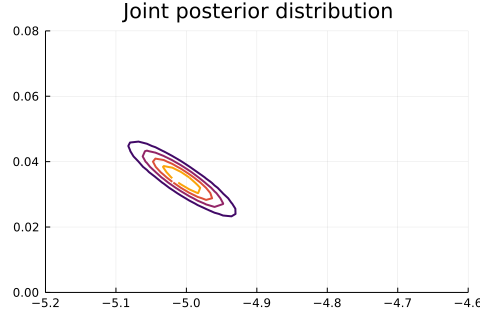

In [86]:
# Solution

joint_posterior = unstack(posterior_pmf)

contour(joint_posterior, title="Joint posterior distribution")

In [87]:
# Solution

marginal_inter = marginal(joint_posterior, 1)
marginal_slope = marginal(joint_posterior, 2)

mean(marginal_inter), mean(marginal_slope)

(-5.006441450493508, 0.034788577236134405)

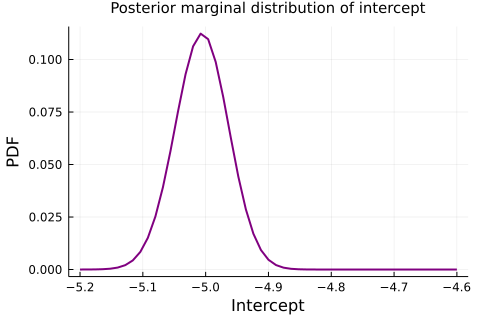

In [88]:
# Solution

plot(marginal_inter, color=:purple,
         xlabel="Intercept",
         ylabel="PDF",
         title="Posterior marginal distribution of intercept",
         titlefontsize=10)

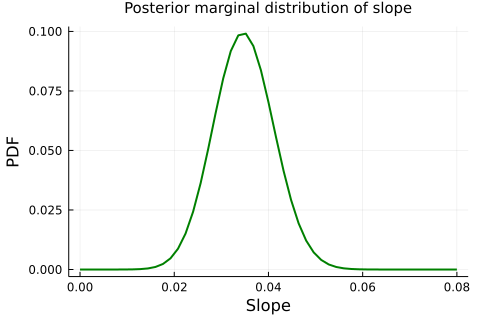

In [89]:
# Solution

plot(marginal_slope, color=:green,
         xlabel="Slope", ylabel="PDF",
         title="Posterior marginal distribution of slope",
         titlefontsize=10)

In [90]:
# Solution

samp = sample(posterior_pmf, 101)
xs = adhd.x

ps = Matrix{Float64}(undef, (length(samp), length(xs)))

for (i, (slope, inter)) in enumerate(samp)
    for j in 1:length(xs)
        ps[i, j] = expit(inter + slope * xs[j])
    end
end

size(ps)

(101, 12)

In [91]:
# Solution

low = percentile.(eachcol(ps), 2.5)
med = percentile.(eachcol(ps), 50)
hi = percentile.(eachcol(ps), 97.5)

12-element Vector{Float64}:
 0.007551718978132539
 0.007715345567131593
 0.007882494291199773
 0.008027677085602649
 0.008227658406306168
 0.008506370503835767
 0.008818918193555243
 0.009186523812050582
 0.009580515493916263
 0.009991290273168509
 0.010469159575990355
 0.010969692500660322

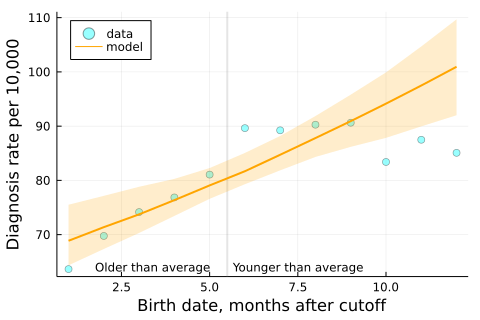

In [92]:
plot_adhd(adhd)
plot!(xs, med .* 10000, color=:orange, label="model", legend=:topleft)
plot!(xs, low .* 10000, fillrange = hi .* 10000, fillalpha = 0.2, lw=0, color = :orange, label="")